# **Machine Learning on Big Data (CN7030) CRWK 21-22**
# **Group ID: 11**
1.   Student 1: Aekkaraj Kuplakatee ID: u2235955
2.   Student 2: Stevin Sam ID: u1802868
---
#####Module leader: **Dr Amin Karami** (a.karami@uel.ac.uk)


# **Initiate and Configure Spark**

---


In [ ]:
#install Apache Spark framwork using python programming language

#install pyspark for python API to interact with spark
!pip3 install pyspark
#Install findspark to set up spark environment 
!pip3 install findspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.3 MB 43 kB/s 
     |████████████████████████████████| 199 kB 72.1 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=35afe60f4988626589a50df9c943af5ae58968ad3b76f90cf6913a1df019f282
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os       #importing os to set environment variable
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null      #install openjdk
  !java -version       #check java version
install_java()

openjdk version "11.0.15" 2022-04-19
OpenJDK Runtime Environment (build 11.0.15+10-Ubuntu-0ubuntu0.18.04.1)
OpenJDK 64-Bit Server VM (build 11.0.15+10-Ubuntu-0ubuntu0.18.04.1, mixed mode, sharing)


In [ ]:
#Configure local Spark using spark session
from pyspark.sql import SparkSession

#Initate Sapark Session to interact with the dataframe 
spark = SparkSession\
  .builder\
  .appName("G11_ML_Classification")\
  .config("spark.some.config.option", "some-value")\
  .getOrCreate()

In [ ]:
#Importing libraries
from google.colab import drive
import pyspark.sql.functions as F
import numpy as np
from pyspark.sql.functions import when
from pyspark.sql.types import StringType, DoubleType
from pyspark.ml.feature import Imputer
from pyspark.sql.functions import col,isnan,count
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.feature import OneHotEncoder
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import UnivariateFeatureSelector
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.feature import IndexToString
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import itertools
from sklearn.metrics import confusion_matrix


# **Load Data**

---


In [ ]:
#Access the dataset through google drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Load the dataset

DF = spark.read.csv('drive/My Drive/Machine Learning/UNSW-NB15.csv',inferSchema=True, header=None)

# **Data Preprocessing**

In [ ]:
#Assign the header columns to dataset
new_col_names = ['Srcip', 'Sport', 'Dstip', 'Dsport','Proto', 'State', 'Dur', 'Sbytes', 'Dbytes', 'Sttl', 'Dttl', 'Sloss', 'Dloss', 'Service', 'Sload', 
            'Dload', 'Spkts', 'Dpkts', 'Swin', 'Dwin', 'Stcpb', 'Dtcpb', 'Smeansz', 'Dmeansz', 'Trans_depth', 'Res_bdy_len', 'Sjit', 'Djit', 'Stime', 
            'Ltime', 'Sintpkt', 'Dintpkt', 'Tcprtt', 'Synack', 'Ackdat', 'Is_sm_ips_ports', 'Ct_state_ttl', 'Ct_flw_http_mthd', 'Is_ftp_login', 'Ct_ftp_cmd',
            'Ct_srv_src', 'Ct_srv_dst', 'Ct_dst_ltm', 'Ct_src_ltm', 'Ct_src_dport_ltm', 'Ct_dst_sport_ltm', 'Ct_dst_src_ltm', 'Attack_cat', 'Label']

#Add the header columns to the dataframe
DF = DF.toDF(*new_col_names)

In [ ]:
#Chechk how manny 0 values are in the dataset
DF.select([F.count(F.when(DF[c] == 0, c)).alias(c) for c in DF.columns]).show(truncate=False, vertical=True)

-RECORD 0-------------------
 Srcip            | 0       
 Sport            | 54043   
 Dstip            | 0       
 Dsport           | 54088   
 Proto            | 0       
 State            | 0       
 Dur              | 8308    
 Sbytes           | 9       
 Dbytes           | 499901  
 Sttl             | 10447   
 Dttl             | 505769  
 Sloss            | 1046943 
 Dloss            | 1050130 
 Service          | 0       
 Sload            | 5104    
 Dload            | 500366  
 Spkts            | 9       
 Dpkts            | 499901  
 Swin             | 1044685 
 Dwin             | 1048108 
 Stcpb            | 1047558 
 Dtcpb            | 1047883 
 Smeansz          | 9       
 Dmeansz          | 499901  
 Trans_depth      | 2334617 
 Res_bdy_len      | 2352987 
 Sjit             | 963103  
 Djit             | 899546  
 Stime            | 0       
 Ltime            | 0       
 Sintpkt          | 1438    
 Dintpkt          | 500400  
 Tcprtt           | 1054715 
 Synack       

In [ ]:
#Clean the dataset by changing all of the 0 values to nan values
for zCol in DF.columns: DF = DF.withColumn(zCol,when(DF[zCol] ==0,np.nan).otherwise(DF[zCol]))
#Because we will use Label column to perform binary classification. SO, we change nan values back to 0 values
DF = DF.withColumn("Label",when(DF.Label == np.nan,0).otherwise(DF.Label))
#Set all missing values in the Attack_cat column to "Noattack" 
DF = DF.withColumn("Attack_cat",when(DF.Attack_cat.isNull(), "NoAttack").otherwise (DF.Attack_cat))

DF.show(2,truncate=False,vertical=True)

-RECORD 0-------------------------
 Srcip            | 59.166.0.3    
 Sport            | 56716.0       
 Dstip            | 149.171.126.8 
 Dsport           | 143.0         
 Proto            | tcp           
 State            | FIN           
 Dur              | 0.82546002    
 Sbytes           | 7812.0        
 Dbytes           | 16236.0       
 Sttl             | 31.0          
 Dttl             | 29.0          
 Sloss            | 30.0          
 Dloss            | 32.0          
 Service          | -             
 Sload            | 75090.25      
 Dload            | 156111.73     
 Spkts            | 122.0         
 Dpkts            | 126.0         
 Swin             | 255.0         
 Dwin             | 255.0         
 Stcpb            | 2.751097753E9 
 Dtcpb            | 2.748686736E9 
 Smeansz          | 64.0          
 Dmeansz          | 129.0         
 Trans_depth      | NaN           
 Res_bdy_len      | NaN           
 Sjit             | 445.25928     
 Djit             | 

In [ ]:
# seperate the string from integer columns to be able to process the Imputer
strCols = [f.name for f in DF.schema.fields if isinstance(f.dataType, StringType)]
dblCols = [f.name for f in DF.schema.fields if isinstance(f.dataType, DoubleType)]

# fill the missing values with the imputer function
imputer=Imputer(inputCols=dblCols,outputCols=dblCols)
model=imputer.fit(DF)
DF=model.transform(DF)

DF.show(2,truncate=False,vertical=True)

-RECORD 0------------------------------
 Srcip            | 59.166.0.3         
 Sport            | 56716.0            
 Dstip            | 149.171.126.8      
 Dsport           | 143.0              
 Proto            | tcp                
 State            | FIN                
 Dur              | 0.82546002         
 Sbytes           | 7812.0             
 Dbytes           | 16236.0            
 Sttl             | 31.0               
 Dttl             | 29.0               
 Sloss            | 30.0               
 Dloss            | 32.0               
 Service          | -                  
 Sload            | 75090.25           
 Dload            | 156111.73          
 Spkts            | 122.0              
 Dpkts            | 126.0              
 Swin             | 255.0              
 Dwin             | 255.0              
 Stcpb            | 2.751097753E9      
 Dtcpb            | 2.748686736E9      
 Smeansz          | 64.0               
 Dmeansz          | 129.0              


In [ ]:
#check the missing values for both nan and null 
DF.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in DF.columns]).show(truncate=False,vertical=True)

-RECORD 0---------------
 Srcip            | 0   
 Sport            | 0   
 Dstip            | 0   
 Dsport           | 0   
 Proto            | 0   
 State            | 0   
 Dur              | 0   
 Sbytes           | 0   
 Dbytes           | 0   
 Sttl             | 0   
 Dttl             | 0   
 Sloss            | 0   
 Dloss            | 0   
 Service          | 0   
 Sload            | 0   
 Dload            | 0   
 Spkts            | 0   
 Dpkts            | 0   
 Swin             | 0   
 Dwin             | 0   
 Stcpb            | 0   
 Dtcpb            | 0   
 Smeansz          | 0   
 Dmeansz          | 0   
 Trans_depth      | 0   
 Res_bdy_len      | 0   
 Sjit             | 0   
 Djit             | 0   
 Stime            | 0   
 Ltime            | 0   
 Sintpkt          | 0   
 Dintpkt          | 0   
 Tcprtt           | 0   
 Synack           | 0   
 Ackdat           | 0   
 Is_sm_ips_ports  | 0   
 Ct_state_ttl     | 0   
 Ct_flw_http_mthd | 0   
 Is_ftp_login     | 0   


In [ ]:
#numeric indexing for the strings (indexing starts from 0)
for cols in strCols:
    indexer = StringIndexer(inputCol=cols, outputCol=cols+"_index")
#fit the indexer model and use it to transform the strings into numeric indices
DF = indexer.fit(DF).transform(DF)

#one-hot-encoding the numeric indices
for cols in strCols:
  ohe = OneHotEncoder(inputCol=cols+"_index" , outputCol=cols+"_OHEVector")
#fit the ohe model and use it to transform the numeric indices into ohe vectors
DF = ohe.fit(DF).transform(DF)

DF.show(1,truncate=False, vertical=True)

-RECORD 0----------------------------------
 Srcip                | 59.166.0.3         
 Sport                | 56716.0            
 Dstip                | 149.171.126.8      
 Dsport               | 143.0              
 Proto                | tcp                
 State                | FIN                
 Dur                  | 0.82546002         
 Sbytes               | 7812.0             
 Dbytes               | 16236.0            
 Sttl                 | 31.0               
 Dttl                 | 29.0               
 Sloss                | 30.0               
 Dloss                | 32.0               
 Service              | -                  
 Sload                | 75090.25           
 Dload                | 156111.73          
 Spkts                | 122.0              
 Dpkts                | 126.0              
 Swin                 | 255.0              
 Dwin                 | 255.0              
 Stcpb                | 2.751097753E9      
 Dtcpb                | 2.748686

In [ ]:
#remove the string columns before combining the dataset into the feature vector
cols=DF.columns
cols.remove("Label")
cols.remove("Dstip")
cols.remove("Proto")
cols.remove("State")
cols.remove("Service")
cols.remove("Attack_cat")
cols.remove("Srcip")

#combine all the features in one single feature vector by using Vector Assembler
assembler = VectorAssembler(inputCols=cols,outputCol="features")
DF=assembler.transform(DF)

DF.select("features").show(5,truncate=True)

+--------------------+
|            features|
+--------------------+
|[56716.0,143.0,0....|
|[43467.0,49729.0,...|
|[41289.0,9574.0,0...|
|[43785.0,6881.0,2...|
|[40691.0,6881.0,2...|
+--------------------+
only showing top 5 rows



In [ ]:
#tranform the dataset to a common standad scale by using the Standard Scaler
standardscaler=StandardScaler().setInputCol("features").setOutputCol("Scaled_features")
DF=standardscaler.fit(DF).transform(DF)

DF.select("features","Scaled_features").show(5,truncate=True)

+--------------------+--------------------+
|            features|     Scaled_features|
+--------------------+--------------------+
|[56716.0,143.0,0....|[2.84445602691735...|
|[43467.0,49729.0,...|[2.17998395729629...|
|[41289.0,9574.0,0...|[2.07075154974593...|
|[43785.0,6881.0,2...|[2.19593249063009...|
|[40691.0,6881.0,2...|[2.04076028265910...|
+--------------------+--------------------+
only showing top 5 rows




# **Task 1 - Binary Classifier**

---


In [ ]:
#For the binary classifier we use Logistic regression to predict the result of the dataset. 

In [ ]:
# Split the dataset into train data and test data using random split in the binary classification (trian: 80%, test: 20%)
trainBC, testBC = DF.randomSplit([0.8, 0.2], seed=12345)§1

In [ ]:
#Observe the imbalance in the dataset using the Where function
DF_size=float(trainBC.select("Label").count())
numPositives=trainBC.select("Label").where('Label == 1').count()

per_ones=(float(numPositives)/float(DF_size))*100
numNegatives=float(DF_size-numPositives)

print('The number of ones are {}'.format(numPositives))
print('Percentage of ones are {}'.format(per_ones))

The number of ones are 257283
Percentage of ones are 12.659889020597175


In [ ]:
#Find the balance ratio in the dataset and balance it by using the class Weights module
BalancingRatio= numNegatives/DF_size
print('BalancingRatio = {}'.format(BalancingRatio))

trainBC=trainBC.withColumn("classWeights", when(trainBC.Label == 1,BalancingRatio).otherwise(1-BalancingRatio))
trainBC.select("classWeights").show(5,truncate=False)

BalancingRatio = 0.8734011097940283
+------------------+
|classWeights      |
+------------------+
|0.1265988902059717|
|0.1265988902059717|
|0.1265988902059717|
|0.1265988902059717|
|0.1265988902059717|
+------------------+
only showing top 5 rows



In [ ]:
#Use Univariate Feature Selector to reduce non-informative features to increase the perdiction result
ufs = UnivariateFeatureSelector(featuresCol="Scaled_features", outputCol="selectedFeatures",labelCol="Label", selectionMode="numTopFeatures")
ufs.setFeatureType("continuous").setLabelType("categorical")
trainBC=ufs.fit(trainBC).transform(trainBC)
testBC=ufs.fit(testBC).transform(testBC)

testBC.select("selectedFeatures").show(5,truncate=True)

+--------------------+
|    selectedFeatures|
+--------------------+
|[1.56480452752354...|
|[1.56480452752354...|
|[1.56480452752354...|
|[1.56480452752354...|
|[1.56480452752354...|
+--------------------+
only showing top 5 rows



In [ ]:
#Use the LogisticRegression classification to predict the dependency of the data
lr = LogisticRegression(labelCol="Label", featuresCol="selectedFeatures",weightCol="classWeights",maxIter=10)
model=lr.fit(trainBC)
predict_train = model.transform(trainBC)
predicted = model.transform(testBC)

predicted.select("Label", "prediction").show(5,truncate=False)

+-----+----------+
|Label|prediction|
+-----+----------+
|0.0  |0.0       |
|0.0  |0.0       |
|0.0  |0.0       |
|0.0  |0.0       |
|0.0  |0.0       |
+-----+----------+
only showing top 5 rows



In [ ]:
#Use the Binary Classification Evaluator to evaluate the area under the ROC curve
IRevaluator=BinaryClassificationEvaluator(rawPredictionCol='rawPrediction',labelCol="Label")
IRaccuracy = IRevaluator.evaluate(predicted, {IRevaluator.metricName: "areaUnderROC"})

predicted.select("Label","prediction","probability").show(5,truncate=False)

+-----+----------+-----------+
|Label|prediction|probability|
+-----+----------+-----------+
|0.0  |0.0       |[1.0,0.0]  |
|0.0  |0.0       |[1.0,0.0]  |
|0.0  |0.0       |[1.0,0.0]  |
|0.0  |0.0       |[1.0,0.0]  |
|0.0  |0.0       |[1.0,0.0]  |
+-----+----------+-----------+
only showing top 5 rows




# **Task 2 - Multi Classifier**

---


In [ ]:
#For multi classifier we use two classifications, which are Random Forset and Naive Bayes Classifications to predict the result of the dataset

In [ ]:
#Split the dataset into train data and test data using random split  in the multi classification (trian: 80%, test: 20%)
trainMC, testMC = DF.randomSplit([0.8, 0.2], seed=12345)

In [ ]:
#Reduce non-informative features to increase the perdiction result
ufs = UnivariateFeatureSelector(featuresCol="Scaled_features", outputCol="selectedFeatures",labelCol="Attack_cat_index", selectionMode="numTopFeatures")
ufs.setFeatureType("continuous").setLabelType("categorical")
trainMC=ufs.fit(trainMC).transform(trainMC)
testMC=ufs.fit(testMC).transform(testMC)

testMC.select("selectedFeatures").show(5,truncate=True)

+--------------------+
|    selectedFeatures|
+--------------------+
|[1.56480452752354...|
|[1.56480452752354...|
|[1.56480452752354...|
|[1.56480452752354...|
|[1.56480452752354...|
+--------------------+
only showing top 5 rows



In [ ]:
#Use the Random Forest Classification to predict the result of the data
rf = RandomForestClassifier(labelCol="Attack_cat_index", featuresCol="selectedFeatures", numTrees=10)
rfmodel=rf.fit(trainMC)
predict_trainMC = rfmodel.transform(trainMC)
rfpredicted = rfmodel.transform(testMC)

rfpredicted.select("Attack_cat", "prediction").show(5,truncate=False)

+----------+----------+
|Attack_cat|prediction|
+----------+----------+
|NoAttack  |0.0       |
|NoAttack  |0.0       |
|NoAttack  |0.0       |
|NoAttack  |0.0       |
|NoAttack  |0.0       |
+----------+----------+
only showing top 5 rows



In [ ]:
#Use the Naive Bayes classification to predict the result of the data 
nb = NaiveBayes(featuresCol='selectedFeatures', labelCol="Attack_cat_index")
nbmodel=nb.fit(trainMC)
predict_trainnb = nbmodel.transform(trainMC)
nbpredicted = nbmodel.transform(testMC)

nbpredicted.select("Attack_cat", "prediction").show(5,truncate=False)

+----------+----------+
|Attack_cat|prediction|
+----------+----------+
|NoAttack  |0.0       |
|NoAttack  |0.0       |
|NoAttack  |0.0       |
|NoAttack  |0.0       |
|NoAttack  |0.0       |
+----------+----------+
only showing top 5 rows



In [ ]:
#Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="Attack_cat_index", outputCol="predictedLabel")
lbpredicted = labelConverter.transform(testMC)

lbpredicted.select("Attack_cat", "predictedLabel").show(5,truncate=False)

+----------+--------------+
|Attack_cat|predictedLabel|
+----------+--------------+
|NoAttack  |NoAttack      |
|NoAttack  |NoAttack      |
|NoAttack  |NoAttack      |
|NoAttack  |NoAttack      |
|NoAttack  |NoAttack      |
+----------+--------------+
only showing top 5 rows



In [ ]:
#Use the Multiclass classification Evaluator to evaluate the prediction accuracy 
evaluator = MulticlassClassificationEvaluator(labelCol="Attack_cat_index", predictionCol="prediction", metricName="accuracy")
rfAccuracy = evaluator.evaluate(rfpredicted)
nbAccuracy = evaluator.evaluate(nbpredicted)

rfpredicted.select("Attack_cat","prediction","probability").show(5,truncate=True)
nbpredicted.select("Attack_cat","prediction","probability").show(5,truncate=True)

+----------+----------+--------------------+
|Attack_cat|prediction|         probability|
+----------+----------+--------------------+
|  NoAttack|       0.0|[0.96236782404737...|
|  NoAttack|       0.0|[0.96236782404737...|
|  NoAttack|       0.0|[0.96236782404737...|
|  NoAttack|       0.0|[0.96236782404737...|
|  NoAttack|       0.0|[0.96236782404737...|
+----------+----------+--------------------+
only showing top 5 rows

+----------+----------+--------------------+
|Attack_cat|prediction|         probability|
+----------+----------+--------------------+
|  NoAttack|       0.0|[0.99999999999999...|
|  NoAttack|       0.0|[0.99999999999999...|
|  NoAttack|       0.0|[0.99999999999999...|
|  NoAttack|       0.0|[0.99999999999999...|
|  NoAttack|       0.0|[0.99999999999999...|
+----------+----------+--------------------+
only showing top 5 rows



# **Task 3 - Performance Measurements**

## **Measurements for Binary Classifer** ##

Area under ROC Curve: 0.8248


/usr/local/lib/python3.7/dist-packages/pyspark/sql/context.py:127: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


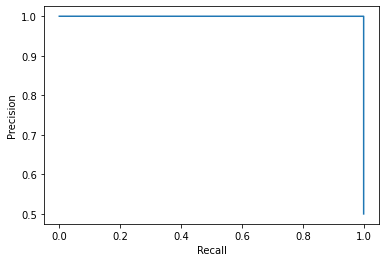

In [ ]:
#check the percentage of the area under the ROC curve
print("Area under ROC Curve: {:.4f}".format(IRaccuracy))
print(model.summary)

#visualise the accuracy of the prediction
pr = model.summary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')

plt.show()

In [ ]:
#show the percentage of acurracy of the perdiction  
print("Model Accuracy",model.summary.accuracy)
#show the false positive rate
print("FP rate",model.summary.falsePositiveRateByLabel)
#show the true positive rate
print("TR rate",model.summary.truePositiveRateByLabel)
#show the total count of actual positive and actual negative
print("Total Actual Positive i.e. Attack Record",predicted.select("Label").where('Label == 1.0').count())
print("Total Actual Negative,i.e. Normal",predicted.select("Label").where('Label == 0.0').count())

Model Accuracy 0.9999994366152747
FP rate [0.0, 1.1267694505703622e-06]
TR rate [0.9999988732305495, 1.0]
Total Actual Positive i.e. Attack Record 64000
Total Actual Negative,i.e. Normal 443470


Confusion matrix, without normalization
[[443470      0]
 [ 64000      0]]


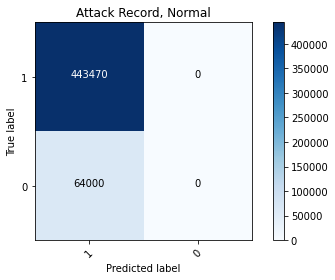

Normalized confusion matrix


<Figure size 432x288 with 0 Axes>

In [ ]:
#defining the fucntion to plt a confrusion matrix
#visualise the total count of the positive and negative results by using the confusion matrix method
def plot_cnf_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
  if normalize:
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print("Normalized confusion matrix")
  else:
    print('Confusion matrix, without normalization') 
    
    print(cm) 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes) 
    
    fmt = '.2f' if normalize else 'd' 
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])): 
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black") 
      plt.tight_layout()
      plt.ylabel('True label')
      plt.xlabel('Predicted label')


y_true = testBC.select("Label")
y_true = y_true.toPandas()
y_pred = predicted.select("prediction")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred)
cnf_matrix

plt.figure()
plot_cnf_matrix(cnf_matrix, classes=[1,0],
title='Attack Record, Normal')
plt.show()

plt.figure()
plot_cnf_matrix(cnf_matrix, classes=[0,1], normalize=True,
title='Normalized confusion matrix')

plt.show()

In [ ]:
FP = cnf_matrix.sum(axis=0) - np.diag(cnf_matrix)  
FN = cnf_matrix.sum(axis=1) - np.diag(cnf_matrix)
TP = np.diag(cnf_matrix)
TN = cnf_matrix.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
print(TPR)

# Specificity or true negative rate
TNR = TN/(TN+FP) 
print(TNR)

# Precision or positive predictive value
PPV = TP/(TP+FP)
print(PPV)

# Negative predictive value
NPV = TN/(TN+FN)
print(NPV)

# Fall out or false positive rate
FPR = FP/(FP+TN)
print(FPR)

# False negative rate
FNR = FN/(TP+FN)
print(FNR)

# False discovery rate
FDR = FP/(TP+FP)
print(FDR)

# Overall accuracy
ACC = (TP+TN)/(TP+FP+FN+TN)
print(ACC)

[1. 0.]
[0. 1.]
[0.87388417        nan]
[       nan 0.87388417]
[1. 0.]
[0. 1.]
[0.12611583        nan]
[0.87388417 0.87388417]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide


## **Measurements for Multi Classfier** ##

In [ ]:
#Show the accuracy results
print("Random Forest:")
print("Test Error = %g" % (1 - rfAccuracy))
print("Test accuracy = ", rfAccuracy)

#Show the accuracy results
print("Naive Bayes:")
print("Test Error = %g" % (1 - nbAccuracy))
print("Test accuracy = ", nbAccuracy)

Random Forest:
Test Error = 0.0153172
Test accuracy =  0.9846828383943879
Naive Bayes:
Test Error = 0.0296904
Test accuracy =  0.9703095749502434


In [ ]:
#Visualise the comparision of the Random Forest and Naive Bayes model
cmpAcc=[rfAccuracy, nbAccuracy]
fig = go.Figure([go.Bar(x=["Random Forest","Naive Bayes"], y=cmpAcc)])
fig.update_layout(
    title="Comparing the Random Forest and Naive Bayes model accuracies",
    autosize=False,
    width=600,
    height=450,
    )
fig.show()

In [ ]:
#defining the fucntion to plt a confrusion matrix (use Random Forest Classification as the main result)
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
#processing the classes for the confusion matrix 
class_temp = rfpredicted.select("Attack_cat").groupBy("Attack_cat").count().sort('count', ascending=False).toPandas()
class_temp = class_temp["Attack_cat"].values.tolist()
class_names = map(str, class_temp)

class_names

Confusion matrix, without normalization
[[443470      0      0      0      0      0      0      0      0      0
       0      0      0      0]
 [     0  43073      0      0      0      0      0      0      0      0
       0      0      0      0]
 [     0      0   8817      0      0      0      0      0      0      0
       0      0      0      0]
 [     0      0      0   3832      0      0      0      0      0      0
       0      0      0      0]
 [     0      0      0      0   3217      0      0      0      0      0
       0      0      0      0]
 [     0      0      0      0      0   2467      0      0      0      0
       0      0      0      0]
 [     0      0      0      0      0      0    937      0      0      0
       0      0      0      0]
 [     0      0      0      0      0      0      0    540      0      0
       0      0      0      0]
 [     0      0      0      0      0      0      0      0    370      0
       0      0      0      0]
 [     0      0      0      0    

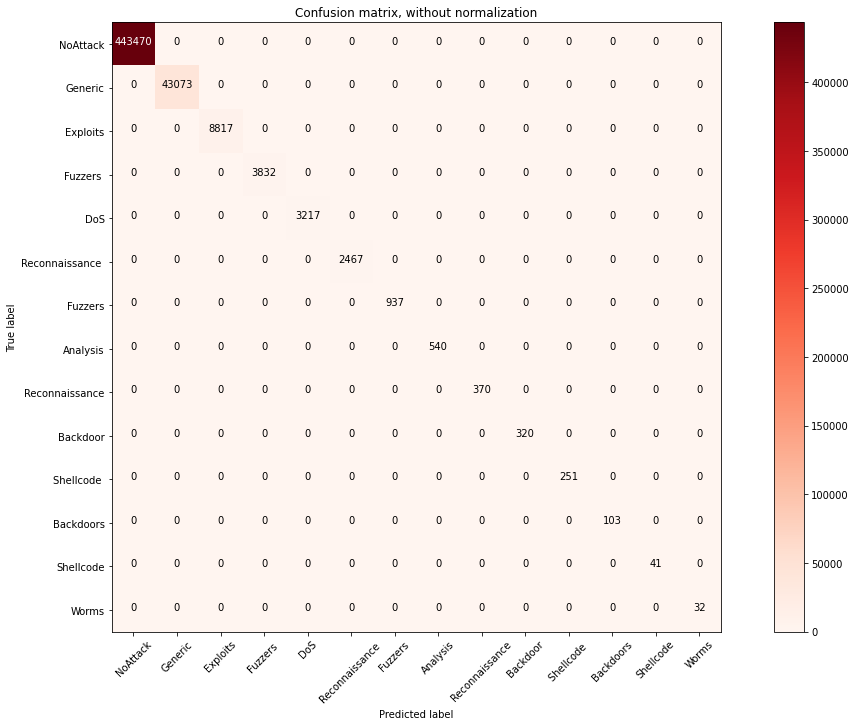

In [ ]:
#visualse the result of the predictions by using the confusion matrix method
y_true = rfpredicted.select("Attack_cat")
y_true = y_true.toPandas()

y_pred = lbpredicted.select("predictedLabel")
y_pred = y_pred.toPandas()

cnf_matrix = confusion_matrix(y_true, y_pred, labels = class_temp)

plt.figure(figsize=(15,10))
plot_confusion_matrix(cnf_matrix, classes=class_temp, title='Confusion matrix, without normalization')
plt.show()

# **Convert ipynb to HTML for Turnitin submission**

---



In [ ]:
!pip3 install nbconvert 

In [ ]:
!jupyter nbconvert  --to html 'drive/My Drive/Colab Notebooks/Group11_for_ML_CN7030.ipynb'

[NbConvertApp] Converting notebook drive/My Drive/Colab Notebooks/Group11_for_ML_CN7030.ipynb to html
[NbConvertApp] Writing 480060 bytes to drive/My Drive/Colab Notebooks/Group11_for_ML_CN7030.html
